# Dog breed classification

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
! python --version

Python 3.8.10


In [3]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://tools.adidas-group.com/artifactory/api/pypi/pypi-trading-sciences/simple
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://tools.adidas-group.com/artifactory/api/pypi/pypi-trading-sciences/simple
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [5]:
! pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://tools.adidas-group.com/artifactory/api/pypi/pypi-trading-sciences/simple
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [6]:
# TODO: Import any packages that you might need
import sagemaker
import os
import boto3
from sagemaker.pytorch import PyTorch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

In [7]:
from smdebug.trials import create_trial
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

[2022-10-26 11:35:40.091 trading-sci-ml-t3-medi-trading-sci-c8ad975c69c3cab09ac328602355:25 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [8]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-10-26 11:35:42--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.56
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  5.10MB/s    in 67s     

2022-10-26 11:36:51 (16.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [9]:
bucket = 'inseason-forecasting-jana-bucket-616469646173-dev'
sagemaker_session = sagemaker.Session()

In [10]:
# copy data to s3
prefix = 'data/dogImages'
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

In [11]:
data_path = f"s3://{bucket}/data/dogImages"

dataset = {
    'train': data_path+'/train',
    'val': data_path+'/valid',
    'test': data_path+'/test'
}

In [12]:
os.environ['SM_CHANNEL_TRAIN'] = dataset['train']
os.environ['SM_CHANNEL_VAL'] = dataset['val']
os.environ['SM_CHANNEL_TEST'] = dataset['test']

In [13]:
s3_output_dir = f"s3://{bucket}/output"
s3_model_dir = f"s3://{bucket}/model"
os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [52]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameters =  {"epochs": "30"}

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.01),
    "batch_size": CategoricalParameter([128, 256, 512]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [53]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="dog-images-HPO",
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [54]:
# TODO: Fit your HP Tuner
tuner.fit(dataset ,wait=False) # TODO: Remember to include your data channels

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-221027-0854


In [55]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-10-27 10:42:23 Starting - Found matching resource for reuse
2022-10-27 10:42:23 Downloading - Downloading input data
2022-10-27 10:42:23 Training - Training image download completed. Training in progress.
2022-10-27 10:42:23 Uploading - Uploading generated training model
2022-10-27 10:42:23 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"512"',
 'epochs': '"30"',
 'lr': '0.006576404654024625',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-images-HPO-2022-10-27-08-54-05-044"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"eu-west-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-eu-west-1-319593880149/dog-images-HPO-2022-10-27-08-54-05-044/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [56]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]
#Define hooks
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [58]:
hyperparameters = {
    "epochs": "30",
    "lr": "0.006576404654024625",
    "batch_size": "512",
}

In [59]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="dog-images-train",
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

In [60]:
# JvL: temp
estimator.fit(dataset)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2022-10-27 11:08:42 Starting - Starting the training job...
2022-10-27 11:09:06 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-10-27 11:10:32 Downloading - Downloading input data.........
2022-10-27 11:13:13 Training - Downloading the training image............
2022-10-27 11:15:14 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-27 11:15:17,067 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-27 11:15:17,101 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-27 11:15:17,110 sagemaker_pytorch_container.training INFO     Invoking user training scr

In [61]:
training_job_name = estimator.latest_training_job.name
print(training_job_name)
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

dog-images-train-2022-10-27-11-08-41-342


In [62]:
# TODO: Plot a debugging output.
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-10-27 12:08:45.391 trading-sci-ml-t3-medi-trading-sci-c8ad975c69c3cab09ac328602355:25 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-eu-west-1-319593880149/dog-images-train-2022-10-27-11-08-41-342/debug-output


In [63]:
trial.tensor_names()

[2022-10-27 12:08:46.882 trading-sci-ml-t3-medi-trading-sci-c8ad975c69c3cab09ac328602355:25 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-10-27 12:08:47.910 trading-sci-ml-t3-medi-trading-sci-c8ad975c69c3cab09ac328602355:25 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [64]:

print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))


1
1


In [65]:
# set up funtions to plot the output tensors

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [66]:

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


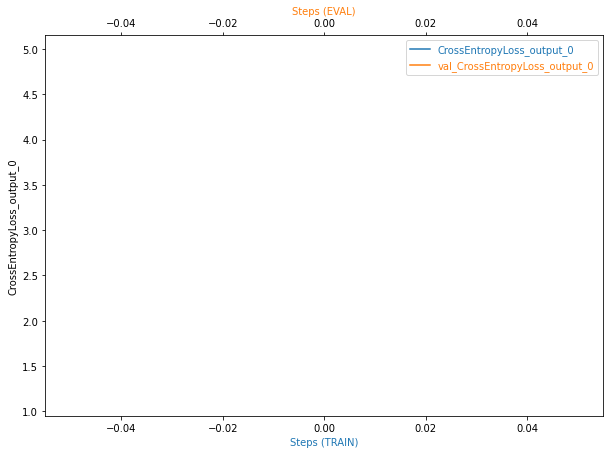

In [70]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [68]:
# TODO: Display the profiler output
session = boto3.session.Session()
region = session.region_name
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-eu-west-1-319593880149/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-eu-west-1-319593880149/dog-images-train-2022-10-27-11-08-41-342/profiler-output


Profiler data from system is available
[2022-10-27 12:09:35.800 trading-sci-ml-t3-medi-trading-sci-c8ad975c69c3cab09ac328602355:25 INFO metrics_reader_base.py:134] Getting 54 event files
selec

You will find the profiler report in s3://sagemaker-eu-west-1-319593880149/dog-images-train-2022-10-27-11-08-41-342/rule-output


## Model Deploying

In [71]:
# TODO: Deploy your model to an endpoint
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") 

INFO:sagemaker:Creating model with name: dog-images-train-2022-10-27-13-20-10-403
INFO:sagemaker:Creating endpoint with name dog-images-train-2022-10-27-13-20-10-403


-------------!

In [102]:
predictor

In [103]:
# TODO: Run an prediction on the endpoint

image_path = "dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg"

In [94]:
from PIL import Image

image = Image.open(image_path)
with open(image_path, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)

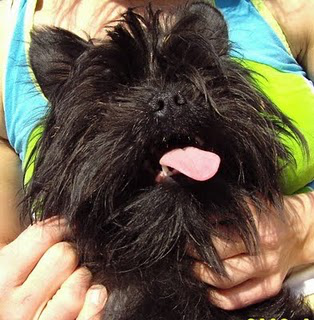

In [95]:
image

In [75]:
# Transform datasets
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [115]:
import torchvision
import numpy as np

In [105]:
image_as_tensor = transform(image)


In [111]:
image_as_tensor.shape

torch.Size([3, 224, 224])

In [107]:
image_loader = torch.utils.data.DataLoader(image_as_tensor)

In [112]:
image_loader

In [ ]:
response = predictor.predict(data = image_as_tensor)

In [121]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: dog-images-train-2022-10-27-13-20-10-403
INFO:sagemaker:Deleting endpoint with name: dog-images-train-2022-10-27-13-20-10-403
